# **Необходимо написать программу, которая принимает на вход регулярное выражение и строит по нему детерминированный конечный автомат. Далее на вход программе подается строка. Полученный конечный автомат должен определить, подходит ли введенная строка под заданное ранее регулярное выражение.**

In [1]:
!sudo apt-get install python-dev graphviz libgraphviz-dev pkg-config

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Note, selecting 'python-dev-is-python2' instead of 'python-dev'
pkg-config is already the newest version (0.29.1-0ubuntu4).
graphviz is already the newest version (2.42.2-3build2).
libgraphviz-dev is already the newest version (2.42.2-3build2).
python-dev-is-python2 is already the newest version (2.7.17-4).
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.


In [2]:
!pip install pygraphviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import pygraphviz as pgv
from IPython.display import Image, display
import re
import numpy as np
from PIL import Image
from typing import Dict, List, Tuple
from typing import Dict, List, Set
import copy

In [4]:
# Определяем типы состояний для NDFA
data_NDFA = Dict[str, List[List[int]]]
# Определяем типы состояний для DFA (используется в качестве прокси-объекта для NDFA)
data_DFA = Dict[str, List[int]]

In [5]:
# Определяем кастомное исключение для случая, когда NDFA не может принять символ входной строки
class char_accept(Exception):
    pass

In [6]:
# Класс NDFA реализует недетерминированный конечный автомат
class NDFA():
    def __init__(self, table: data_NDFA, last_states: List[int]):
        self.table = table           # таблица состояний, символов перехода и новых состояний
        self.last_states = last_states  # список финальных состояний

        self.states = None   # текущие состояния автомата

    # Выполняем переход из стартового состояния start в конечное состояние finish по символу char
    def transition(self, start, char, finish):
        if char not in self.table:
            self.table[char] = [[] for _ in range(self.all_states())]
        self.table[char][start].append(finish)

    # Получаем следующее состояние, которое будет получено, если применить символ char к состоянию state
    # Выполняем проверку наличия символа в таблице состояний
    def get_next_state(self, state: int, char: str) -> List[int]:
        if char not in self.table:
            raise char_accept
        return self.table[char][state]

    # Получаем список новых состояний, которые будут получены при применении символа char к состоянию previous_state
    # Выполнение замыкания "ε" происходит по формуле: close_eps = найти все epsilon-переходы из выходных состояний предыдущего шага (sum([self.close_eps(s) for s in new_state], []) )
    def get_states_after_transition(self, previous_state, char: str):
        new_state = set()
        for state in previous_state:
            new_state.update(self.get_next_state(state, char))
            if 'ε' in self.table.keys():
                new_state.update(sum([self.close_eps(s) for s in new_state], []))
        return list(new_state)

    # Находим замыкание "ε" состояния state (выполняем обход по графу из состояния state и находим все состояния, которые можно достичь только по "ε"-переходам)
    def close_eps(self, state: int) -> List[int]:
        if 'ε' not in self.table.keys():
            return [state]
        visited = []
        current = [state]
        while len(current) != 0:
            new_current = []
            for s in current:
                new_current.extend(self.table['ε'][s])
            visited = list(set(visited + current))
            current = list(set(new_current).difference(visited))
        return visited

    '''
    - Проверяем, может ли автомат принять входную строку input_str
    - Начальным состоянием автомата всегда является нулевое состояние
    - Выполняем замыкание "ε" для нулевого состояния
    - Применяем последовательно каждый символ входной строки и вычисляем новые состояния автомата
    - Находим пересечение всех текущих состояний и финальных состояний, и если есть хотя бы одно пересечение, то возвращаем True, иначе False
    '''
    def check_interection(self, input_str: str) -> bool:
        self.states = self.close_eps(0)
        try:
            for c in input_str:
                self.states = self.get_states_after_transition(self.states, c)
            for state in self.states:
                if set(self.close_eps(state)).intersection(self.last_states):
                    return True
            return False
        except char_accept:
            return False

    # Возвращаем алфавит автомата (список символов переходов)
    def alphabet(self):
        return list(self.table.keys())

    # Определяем количество состояний в автомате
    def all_states(self):
        return len(list(self.table.values())[0])

    # Создаем копию автомата (копируем таблицу состояний и финальных состояний)
    def copy(self):
        new_table = copy.deepcopy(self.table)
        new_actual = copy.deepcopy(self.last_states)
        return NDFA(new_table, new_actual)

    # Рисуем граф, представляющий автомат (используем библиотеку pygraphviz)
    # Итерируем по всем строкам таблицы состояний, для каждой комбинации из стартового состояния i и перехода s_val к конечному состоянию k добавляем в граф ребро, а также добавляем символ char на ребро
    # Запоминаем в result список финальных состояний и выводим его на экран
    def draw_graph(self, title):
      G=pgv.AGraph()
      G=pgv.AGraph(strict=False,directed=True)
      to_append = 'digraph G {size="4,4"; label="%s";'%title
      for char, state_list in self.table.items():
          for i, s in enumerate(state_list):
            for s_val in s:
              to_append = to_append + '%s -> %s [label="%s"];'%(i,s_val,char)
      to_append = to_append + 'rankdir=LR{ %s [shape=circle]'%self.last_states[0]
      to_append = to_append + '}'
      to_append = to_append + '}'
      A=pgv.AGraph(to_append)
      A.layout()
      A.layout(prog='dot')
      A.draw('automaton.png')
      a = Image.open('automaton.png')
      a.show()
      return to_append, self.last_states

In [7]:
# Класс DFA реализует детерминированный конечный автомат
class DFA():
    def __init__(self, table: data_DFA, last_states: List[int]):
        self.table = table           # таблица состояний, символов перехода и новых состояний
        self.last_states = last_states  # список финальных состояний
        proxy_table = {}
        # Создаем структуру данных старшего уровня для таблицы переходов (заменяем структуру списка списков из NDFA на словарь списков)
        for char, states in table.items():
            proxy_table[char] = [[state] if state is not None else [] for state in states]
        # Создаем прокси-объект NDFA для хранения таблицы переходов DFA (таким образом, мы можем использовать все методы NDFA для DFA)
        self.proxy = NDFA(proxy_table, last_states)

    # Проверяем, может ли автомат принять входную строку input_str (используем метод check_interection прокси-объекта NDFA)
    def check_interection(self, input_str: str) -> bool:
        return self.proxy.check_interection(input_str)

    # Определяем количество состояний в автомате (используем метод all_states прокси-объекта NDFA)
    def all_states(self):
        return self.proxy.all_states()

    # Возвращаем алфавит автомата (список символов переходов) (используем метод alphabet прокси-объекта NDFA)
    def alphabet(self):
        return self.proxy.alphabet()

    # Рисуем граф, представляющий автомат (используем метод draw_graph прокси-объекта NDFA)
    def draw_graph(self, title):
        return self.proxy.draw_graph(title)

In [8]:
class Generator:
  # Функция инициализации класса. В ней определяются начальные значения переменных и вызывается функция создания детерминированного автомата (DFA)
  def __init__(self, regex):
      # Алфавит символов
      self.alphabet = []
      # Состояния автомата.
      self.states = []
      # Регулярное выражение, для которого создается автомат
      self.regex = regex
      # Операции – знаки, использующиеся в регулярном выражении
      self.operations = {'*': self.multiply, '+': self.plus, '|': self.alternate, ',': self.concatenate, '?': self.optional}
      # Приоритеты операций
      self.priorities = {'|': 0, ',': 1, '*': 2, '+': 2, '?': 2}
      # Начальное состояние автомата
      self.current_state = 0
      # Функция перехода между состояниями автомата
      self.transition = []
      # Пустые переходы
      self.empty_transitions = []
      # Создание детерминированного автомата
      self.dfa = self.dfa_create(regex)
      # Финальное состояние автомата
      self.final_state = self.states[-1]

  def concatenate(self, A, B):
    # Объединение двух автоматов
    merged = self.merge_tables(A, B)
    # Добавляем пустые переходы от всех конечных состояний автомата A к состояниям автомата B
    for start in A.last_states:
        merged.transition(start, 'ε', A.all_states())
    # Находим все конечные состояния полученного автомата
    merged.last_states = [s + A.all_states() for s in B.last_states]
    return merged

  def alternate(self, A, B):
      # Сливаем таблицы переходов автоматов A и B
      merged = self.merge_tables(A, B)

      # Сдвигаем финальные состояния на 1
      shifted_finals = [f + 1 for f in merged.last_states]

      # Создаем новую таблицу переходов, сдвигая состояния на 1
      shifted_table = {}
      for char, state_list in merged.table.items():
          shifted_table[char] = [[]] + [[state + 1 for state in states] for states in state_list] + [[]]

      # Создаем новый автомат
      new = NDFA(table=shifted_table, last_states=[])

      # Добавляем возможность перехода из начального состояния в состояния 1 и A.all_states() + 1
      new.transition(0, 'ε', 1)
      new.transition(0, 'ε', A.all_states() + 1)

      # Добавляем возможность перехода из финальных состояний в новое финальное состояние
      for f in shifted_finals:
          new.transition(f, 'ε', new.all_states() - 1)

      # Добавляем новое финальное состояние
      new.last_states = [new.all_states() - 1]

      # Возвращаем новый автомат
      return new

  # Функция умножения автомата на себя
  def multiply(self, A):
      # Сдвигаем финальные состояния на 1
      shifted_finals = [f + 1 for f in A.last_states]

      # Создаем новую таблицу переходов, сдвигая состояния на 1
      shifted_table = {}
      for char, state_list in A.table.items():
          shifted_table[char] = [[]] + [[state + 1 for state in states] for states in state_list] + [[]]

      # Создаем новый автомат
      new = NDFA(table=shifted_table, last_states=[])

      # Добавляем возможность перехода из финальных состояний в новое начальное состояние и новое финальное состояние
      for f in shifted_finals:
          new.transition(f, 'ε', 1)
          new.transition(f, 'ε', new.all_states() - 1)

      # Добавляем возможность перехода из начального состояния в состояния 1 и новое финальное состояние
      new.transition(0, 'ε', 1)
      new.transition(0, 'ε', new.all_states() - 1)

      # Добавляем новое финальное состояние
      new.last_states = [new.all_states() - 1]

      # Возвращаем новый автомат
      return new

  # Функция объединения автоматов
  def plus(self, A):
      # Объединяем автомат с умножением автомата на себя
      return self.concatenate(A, self.multiply(A))

  # Функция создания неопределенности
  def optional(self, A):
      # Создаем копию автомата A
      A_copy = A.copy()

      # Добавляем возможность перехода из начального состояния во все финальные состояния автомата A
      for f in A_copy.last_states:
          A_copy.transition(0, 'ε', f)

      # Возвращаем автомат с добавленными переходами
      return A_copy

  # Функция выполнения операции между двумя автоматами
  def perform_operation(self, operation, A, B = None):
      if operation == '|':
          # Если операция | (альтернатива), то вызываем функцию alternate
          self.alternate(A, B)
      elif operation == ',':
          # Если операция , (конкатенация), то вызываем функцию concatenate
          self.concatenate(A, B)
      elif operation == '*':
          # Если операция * (звезда Клини), то вызываем функцию multiply
          self.multiply(A)
      elif operation == '+':
          # Если операция + (плюс Клини), то вызываем функцию plus
          self.plus(A)
      elif operation == '?':
          # Если операция ? (неопределенность), то вызываем функцию optional
          self.optional(A)

  # Функция перехода состояния при вводе символа
  def transition_to_state_with_input(self, input_value):
          if ((self.current_state, input_value) not in self.transition.keys()):
              # Если текущее состояние автомата не имеет перехода по заданному символу, проверяем наличие пустого перехода
              if self.current_state in self.empty_transitions.keys():
                # Если есть пустой переход, переходим по нему
                self.current_state = self.empty_transitions[self.current_state]
                # Если перехода и по пустому символу нет, то автомат не может принять входную строку
                if ((self.current_state, input_value) not in self.transition_function.keys()):
                  self.current_state = None;
                  return;
              # Если у текущего состояния нет переходов ни по заданному символу, ни по пустому символу, то автомат не может принять входную строку
              else:
                self.current_state = None;
                return;
          # Если есть переход по данному символу, переходим по нему
          self.current_state = self.transition[(self.current_state, input_value)];
          return;

  def char_check(self, c):
    # Проверяем, является ли символ c оператором регулярного выражения
    return c not in (list(['*', '+', '|', ',', '?']) + ['(', ')'])

  # Функция проверки вводимого слова на принадлежность к языку, заданному автоматом.
  def word_check(self, word):
        if(self.dfa_check(word, self.states)):
          print("Passed")
        else:
          print("Not passed")

  def split(self, DFA, target, splitter, split_char) -> Tuple[set, set]:
      # Создание двух новых множеств состояний
      R1 = set()
      R2 = set()
      # Для каждого состояния из целевого множества проверяем, в какое из двух новых множеств оно должно быть добавлено
      for v in target:
          if DFA.table[split_char][v] in splitter:
              R1.add(v)
          else:
              R2.add(v)
      # Возврат двух новых множеств состояний
      return R1, R2

  def parse_graph(self, to_append):
    # Создаем словарь для хранения переходов между состояниями
    data_arr = dict()
    # Создаем пустой словарь
    data_arr_empty = dict()
    # Создаем пустой список состояний
    states = []
    # Создаем списки для хранения начальных и конечных состояний переходов
    from_values = []
    to_values = []
    # Создаем списки пар начальных и конечных состояний
    start_pairs = []
    final_pairs = []
    # Разбиваем строку на части по разделителю ';'
    parts = to_append.split(';')
    # Находим максимальное количество частей
    max = len(parts)


    # Проходим по каждой части разделенной строки
    for idx, part in enumerate(parts):
      # Если это последняя часть, то проходимся по всем начальным и конечным состояниям и заполняем пустой словарь
      if idx == max - 1:
        for i in range(len(from_values)):
            # добавляем пары начальных и конечных состояний
            start_pairs.append([from_values[i], to_values[i]])
            final_pairs.append([from_values[i], to_values[i]])
            data_arr_empty[int(from_values[i])] = int(to_values[i])
      # Если это не последняя часть и не первая и не вторая
      elif idx != max - 1 and idx != 0 and idx != 1:
        # Разбиваем часть на части по пробелу
        values = part.split(' ')
        # Если количество частей равно 3, то это простой переход
        if len(values) == 3:
          # Добавляем начальное и конечное состояние в список состояний
          fromValue = int(values[0])
          states.append(fromValue)
          toValue = int(values[2])
          states.append(toValue)
          # Добавляем начальное и конечное состояние в списки начальных и конечных состояний перехода
          from_values.append(fromValue)
          to_values.append(toValue)
        # Если количество частей равно 4 и уже были добавлены начальные и конечные состояния перехода
        elif len(values) == 4 and len(from_values)!= 0:
          # Добавляем начальное и конечное состояние в список состояний
          fromValue = int(values[0])
          states.append(fromValue)
          toValue = int(values[2])
          states.append(toValue)
          # Добавляем начальное и конечное состояние в списки начальных и конечных состояний перехода
          from_values.append(fromValue)
          to_values.append(toValue)
          # Находим метку перехода
          label = re.search('\"(.+?)\"', values[3]).group(1)

          # Добавляем начальное и конечное состояние и метку перехода в словарь переходов
          for i in range(len(from_values)):
            start_pairs.append([from_values[i], to_values[i]])
            final_pairs.append([from_values[i], to_values[i]])
            data_arr[(int(from_values[i]),label)] = int(to_values[i])
          # Очищаем списки начальных и конечных состояний перехода
          from_values = []
          to_values = []
        # Если количество частей равно 4 и еще не были добавлены начальные и конечные состояния перехода
        elif len(values) == 4 and len(from_values) == 0:
          # Добавляем начальное и конечное состояние в список состояний
          fromValue = int(values[0])
          states.append(fromValue)
          toValue = int(values[2])
          states.append(toValue)
          # Находим метку перехода
          label = re.search('\"(.+?)\"', values[3]).group(1)
          # Добавляем начальное и конечное состояние и метку перехода в словарь переходов
          data_arr[(int(fromValue),label)] = int(toValue)
          # Очищаем списки начальных и конечных состояний перехода
          from_values = []
          to_values = []

    # Сохраняем словарь переходов
    self.transition = data_arr
    # Находим все пары начальных и конечных состояний, которые не были соединены ребром
    for p1 in start_pairs:
      for p2 in final_pairs:
        if p1[0] == p2[1] and p1[1] == p2[0]:
          data_arr_empty[int(p1[0])] = int(p1[1])
          data_arr_empty[int(p1[1])] = int(p1[0])
    # Находим все уникальные состояния и сохраняем их в списке состояний
    states = sorted(np.unique(np.array(states), axis = 0))
    # Сохраняем список состояний автомата
    self.states = states
    # Сохраняем список конечных состояний автомата
    self.accept_states =  states[1:]
    # Сохраняем пустые переходы автомата
    self.empty_transitions = data_arr_empty

  def prepare_regexp(self, regexp: str) -> str:
    # Функция для преобразования регулярного выражения для корректного парсинга
    if len(regexp) == 0:
        return ''
    new = []
    last = None
    for c in regexp:
        if last is None:
            # если нет предыдущего символа, добавляем текущий символ в новый список
            last = c
            new.append(c)
            continue
        if last in ['*', '+', '?'] and c == '(' \
                or last in ['*', '+', '?'] and self.char_check(c) \
                or self.char_check(last) and self.char_check(c) \
                or last == ')' and self.char_check(c) \
                or self.char_check(last) and c == '(':
            # Если предыдущий символ является оператором регулярного выражения и текущий символ соответствует определенным правилам, то добавляем запятую
            new.append(',')
        new.append(c)
        last = c
    return ''.join(new)

  # Функция слияния таблиц переходов двух автоматов
  def merge_tables(self, A, B):
      # Создаем объединенный список ключей таблиц переходов автоматов A и B
      keys = set(list(A.table.keys()) + list(B.table.keys()))

      # Создаем список новых финальных состояний, сдвигая их на A.all_states()
      new_actual = [state + A.all_states() for state in B.last_states]
      new_actual.extend(A.last_states)

      # Создаем новую таблицу переходов, сдвигая состояния в обоих автоматах на 1
      new_table = {}
      for k in keys:
          new_row = []
          if k in A.table:
              new_row.extend(A.table[k])
          else:
              new_row.extend([[] for _ in range(A.all_states())])
          if k in B.table:
              new_row.extend([[s + A.all_states() for s in states] for states in B.table[k]])
          else:
              new_row.extend([[] for _ in range(B.all_states())])
          new_table[k] = new_row

      # Возвращаем новый автомат с объединенными таблицами переходов и финальными состояниями
      return NDFA(table=new_table, last_states=new_actual)

  def initial_NDFA(self, actual_string):
      # Создание пустого словаря для хранения переходов
      table: Dict[str, List[List[int]]] = {}
      # Поиск индекса и значения каждого символа в строке
      for i, c in enumerate(actual_string):
          # Если символ еще не добавлен в таблицу, то добавить его и создать пустую ячейку для каждого возможного перехода
          if c not in table:
              table[c] = [[] for _ in range(len(actual_string) + 1)]
          # Заполнить пустую ячейку текущего символа значением i+1
          table[c][i].append(i + 1)
      # Создание НКА с полученной таблицей и единственным завершающим состоянием
      return NDFA(table=table, last_states=[len(actual_string)])

  def create_NDFA(self, regexp):
      # Создание пустых стеков для операций и автоматов, а также буфера для хранения символов регулярного выражения
      op_stack = []
      automata_stack = []
      buffer = ''

      # Вспомогательная функция для обработки операций с различными приоритетами
      def processing(priority=-1):
          while len(op_stack) != 0 \
                  and op_stack[-1] != '(' \
                  and (op_stack[-1] not in ['*', '+', '|', ',', '?'] or self.priorities[op_stack[-1]] > priority):
              op = op_stack[-1]
              if op in ['|', ',']:
                  automata_stack.append(self.operations[op](automata_stack[-2], automata_stack[-1]))
                  automata_stack.pop(-2)
                  automata_stack.pop(-2)
                  op_stack.pop()
              elif op in ['*', '+', '?']:
                  automata_stack.append(self.operations[op](automata_stack[-1]))
                  automata_stack.pop(-2)
                  op_stack.pop()
          if priority == -1 and len(op_stack) != 0 and op_stack[-1] == '(':
              op_stack.pop()

      # Подготовка регулярного выражения (удаление пробелов и добавление явных операций конкатенации)
      regexp = self.prepare_regexp(regexp)

      # Цикл по всем символам регулярного выражения
      for c in regexp:
          if c in list(['*', '+', '|', ',', '?']) + ['(', ')']:
              # Если текущий символ - оператор или скобка, то добавить в создание автомата все символы из буфера
              if buffer != '':
                  automata_stack.append(self.initial_NDFA(buffer))
              buffer = ''
          if c in ['*', '+', '|', ',', '?']:
              # Если текущий символ - оператор, то обработать стек операций и автоматов
              if len(op_stack) == 0 or op_stack[-1] in ['(', ')'] or self.priorities[op_stack[-1]] < self.priorities[c]:
                  op_stack.append(c)
              else:
                  processing(self.priorities[c])
                  op_stack.append(c)
          elif c == '(':
              op_stack.append('(')
          elif c == ')':
              processing()
          else:
              # Добавление символа в буфер
              buffer += c

      # Добавление в создание автомата все символы из буфера
      if buffer != '':
          automata_stack.append(self.initial_NDFA(buffer))
      # Обработка оставшихся операций и автоматов
      processing()
      # Возвращение полученного автомата
      return automata_stack[-1]

  def convert_NDFA_to_DFA(self, NDFA):
      # Создание списка связей между состояниями и списка новых состояний
      links = []
      newStates = [set(NDFA.close_eps(0))]
      visitedStates = []
      alphabet = [x for x in list(NDFA.table.keys()) if x != 'ε']
      # Цикл создания новых состояний
      while len(newStates) > 0:
          tmp = newStates.pop()
          if tmp in visitedStates:
              continue
          visitedStates.append(tmp)
          # Поиск всех состояний, в которые можно перейти из текущего состояния по каждому символу алфавита
          for char in alphabet:
              newTmp = set(NDFA.get_states_after_transition(tmp, char))
              if len(newTmp) != 0:
                  newStates.append(newTmp)
                  links.append((tmp, char, newTmp))
      # Форматирование связей между состояниями
      formatted_links = []
      for link in links:
          formatted_links.append((visitedStates.index(link[0]), link[1], visitedStates.index(link[2])))
      links = formatted_links
      # Поиск новых завершающих состояний в полученном автомате
      old_final = set(NDFA.last_states)
      new_actual = [i for i, s in enumerate(visitedStates) if s.intersection(old_final)]
      new_table = {}
      # Создание новой таблицы переходов
      for k in alphabet:
          new_table[k] = [None for _ in enumerate(visitedStates)]
      for link in links:
          new_table[link[1]][link[0]] = link[2]
      # Создание нового ДКА (детерминированного конечного автомата) на основе полученной таблицы и завершающих состояний
      return DFA(table=new_table, last_states=new_actual)

  def minimize_fda(self, fda):
      # Инициализация множеств
      # Одно множество - множество принимающих состояний финального Автомата
      sets = [{*fda.last_states}]

      # Второе множество - множество непринимающих состояний
      non_final = {*list(range(fda.all_states()))}.difference(fda.last_states)
      if len(non_final) > 0:
          sets.append(non_final)

      # Инициализируем очередь
      queue = []
      for c in fda.alphabet():
          for s in sets:
              queue.append((s, c))

      # Процесс декомпозиции для минимизации
      while len(queue) > 0:
          # Извлекаем элемент из очереди
          splitter, char = queue.pop(0)
          for s in sets:
              # Расщепляем состояния в множества
              R1, R2 = self.split(fda, s, splitter, char)
              if len(R1) > 0 and len(R2) > 0:
                  # Удаляем предыдущее множество и добавляем новые множества
                  sets.remove(s)
                  sets.extend([R1, R2])

                  # Работа с очередью
                  if (s, char) in queue:
                      queue.remove((s, char))
                      queue.append((R1, char))
                      queue.append((R2, char))
                  else:
                      if len(R1) < len(R2):
                          queue.append((R1, char))
                      else:
                          queue.append((R2, char))

      # Первое множество - множество таких состояний, что 0 в этом множестве
      first_state_index = [sets.index(s) for s in sets if 0 in s][0]
      first_state = sets.pop(first_state_index)
      sets.insert(0, first_state)

      # Создание новой таблицы и заполнение ее данными
      all_states = len(sets)
      new_table = {k: [None] * all_states for k in fda.alphabet()}
      self.alphabet = fda.alphabet()
      self.start_state = 0
      for i, s in enumerate(sets):
          for v in s:
              for c in fda.alphabet():
                  new_indexes = [sets.index(s) for s in sets if fda.table[c][v] in s]
                  new_table[c][i] = None if len(new_indexes) == 0 else new_indexes[0]

      # Новые принимающие состояния
      new_actual = [sets.index(s) for s in sets if s.intersection(fda.last_states)]

      # Создание и возвращение нового DFA
      return DFA(table=new_table, last_states=new_actual)

  # Проверка, является ли текущее состояние автомата финальным
  def in_accept_state(self, accept_states):
          return self.current_state in accept_states;

  # Проверка входной строки на принадлежность языку, заданному автоматом.
  def dfa_check(self, input_list, accept_states):
          # Устанавливаем текущее состояние автомата.
          self.current_state = self.start_state;
          # Переходим от состояния к состоянию в зависимости от входных символов.
          for inp in input_list:
              self.transition_to_state_with_input(inp);
              continue;
          # Проверяем, является ли текущее состояние автомата финальным.
          return self.in_accept_state(self.last_states);


  # Функция создания детерминированного автомата для регулярного выражения.
  def dfa_create(self, regexp):
    # Создание недетерминированного автомата.
    NDFA = self.create_NDFA(regexp)
    # Построение графа недетерминированного автомата.
    print("NDFA")
    NDFA.draw_graph(self.regex)
    # Преобразование недетерминированного автомата в детерминированный автомат.
    fda = self.convert_NDFA_to_DFA(NDFA)
    # Построение графа детерминированного автомата.
    print("FDA")
    fda.draw_graph(self.regex)
    # Преобразование детерминированного автомата в минимальный детерминированный автомат.
    min_fda = self.minimize_fda(fda)
    # Построение графа минимального детерминированного автомата.
    print("LAST")
    graph, last_states = min_fda.draw_graph(self.regex)
    # Запоминаем финальные состояния автомата.
    self.last_states = last_states
    # Парсим граф автомата.
    self.parse_graph(graph)


  def print_values(dfa):
      # Вывод состояний, алфавита и принимающих состояний
      print("states")
      print(dfa.states)
      print('alphabet')
      print(dfa.alphabet)
      print('accept_states')
      print(dfa.accept_states)

      # Вывод номера умножаемого состояния, таблицы переходов и пустых переходов
      print('start_state')
      print(dfa.start_state)
      print('transition')
      print(dfa.transition)
      print('empty_transition')
      print(dfa.empty_transitions)



NDFA


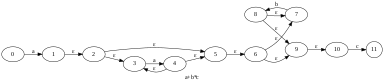

FDA


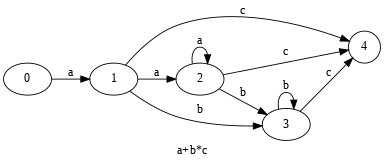

LAST


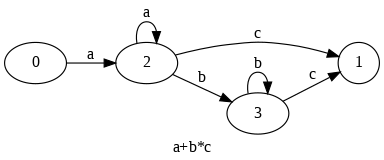

In [9]:
example1 = Generator('a+b*c')

In [10]:
example1.word_check('aab')

Not passed


In [11]:
example1.word_check('c')

Not passed


In [12]:
example1.word_check('abc')

Passed


In [13]:
example1.word_check('aabc')


Passed


In [14]:
example1.word_check('cba')

Not passed


In [15]:
example1.word_check('cab')

Not passed


In [16]:
example1.word_check('abbbbbc')

Passed
